# importing & Set-up

- test different models in the ensembles (random forest, xgb etc)
- add linear model, lasso or ridge
- normalize the data 
- removing outliers
- target encoding based on cluster
- psuedo labeling
- encode the target nigga
- train without the engineered features
- train on subsets of data - like the first 1000
- cluster based on target

# if you faced errors: 
- reduce the number of clusters in `n_clusters`

In [1]:
import pandas as pd                                    
import numpy as np     
from sklearn.utils.class_weight import compute_class_weight   
from sklearn.preprocessing import StandardScaler               
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error         
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit, StratifiedGroupKFold,StratifiedKFold 
from sklearn.preprocessing import LabelEncoder         
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import f1_score,roc_auc_score, roc_curve, auc,log_loss
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sys, os, contextlib
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

@contextlib.contextmanager
def suppress_output(): 
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try: 
            yield
        finally: 
            sys.stdout = old_stdout
            sys.stderr = old_stderr
            
# Initialize models

class CFG:
  data_folder ="../data/"

def reading_data(path: str) -> pd.DataFrame:
  sample = pd.read_csv(path + "SampleSubmission.csv")
  train = pd.read_csv(path + 'Train.csv')
  test = pd.read_csv(path + 'Test.csv')
  return sample,train,test

sample,train,test = reading_data(CFG.data_folder)
sample_id = sample['id']
test_id = test['id']
train_id = train['id']

seed = 7 
tiney_fraction = 1e-05

#pd.options.display.max_columns = 200
n_splits = 5
gkf = StratifiedGroupKFold(n_splits=n_splits)
train.fillna(method='ffill',inplace=True)
test.fillna(method='ffill',inplace=True)

misslead = [2, 12, 29, 31, 38, 77, 81, 97, 102, 115, 116, 130, 131, 133, 136, 143,
            146, 150, 153, 171, 180, 220, 221, 225, 231, 233, 244, 249, 270, 271, 274,
            283, 303, 343, 355, 396, 409, 417, 424, 435, 467, 470, 492, 495, 496, 515, 
            545, 551, 560, 579, 585, 586, 589, 592, 598, 611, 617, 636, 654, 656, 664, 683,
            688, 718, 721, 726, 754, 784, 788, 806, 812, 842, 855, 857, 862, 894, 900, 904,
            924, 947, 960, 980, 994, 1011, 1012, 1017, 1020, 1023, 1024, 1025, 1034, 1040, 
            1045, 1057, 1061, 1081, 1086, 1121, 1122, 1138, 1151, 1156, 1178, 1207, 1211, 1224, 
            1240, 1243, 1246, 1255, 1262, 1267, 1286, 1302, 1315, 1334, 1336, 1358, 1366, 1367,
            1392, 1405, 1427, 1461, 1465, 1474, 1504, 1513, 1517, 1521, 1522, 1530, 1534, 1585, 
            1587, 1604, 1608, 1614, 1615, 1619, 1625, 1646, 1649, 1652, 1656, 1657, 1665, 1674,
            1677, 1708, 1736, 1740, 1795, 1800, 1803, 1807, 1810, 1831, 1845, 1851, 1861, 1869,
            1876, 1877, 1886, 1893, 1898, 1900, 1930, 1953, 1954, 1967, 1994, 1999, 2020, 
            2029, 2034, 2050, 2055, 2056, 2065, 2066, 2086, 2095, 2105, 2120, 2122]

#train = train.drop(index=misslead).reset_index(drop=True)
#test = test.drop(index=misslead).reset_index(drop=True)

lgbm_model = CatBoostClassifier(random_state=seed)
svm_model = SVC(probability=True, random_state=seed)
knn_model = KNeighborsClassifier()

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_52686/3029889080.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill',inplace=True)
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_52686/3029889080.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill',inplace=True)


In [3]:

classes = train['Target'].unique()
indices_to_remove = []
for idx in misslead:
    target_value = train.loc[idx, 'Target']
    other_samples = train[(train['Target'] == target_value) & (train.index != idx)]
    if len(other_samples) > 0:
        indices_to_remove.append(idx)
train = train.drop(indices_to_remove)
train_id = train['id']

In [6]:
#setup clusters 
kmeans = KMeans(n_clusters=2)

lat_min, lat_max = 44.92469405, 45.88973369
lon_min, lon_max = 8.736496578, 12.59068235

num_clusters_lat = 6
num_clusters_lon = 6
lat_step = (lat_max - lat_min) / num_clusters_lat
lon_step = (lon_max - lon_min) / num_clusters_lon
def assign_clusters(row, lat_step, lon_step, lat_min, lon_min):
    lat_cluster = ((row['LAT2'] - lat_min) / lat_step)
    lon_cluster = ((row['LON1'] - lon_min) / lon_step)
    return lat_cluster, lon_cluster
for dataset in (train, test):
    dataset[['lat_cluster', 'lon_cluster']] = dataset.apply(
        assign_clusters, axis=1, result_type='expand',
        lat_step=lat_step, lon_step=lon_step, lat_min=lat_min, lon_min=lon_min)

In [7]:
geospatial_columns = ['LAT2', 'LON1', 'ELEV1', 'PEND1']
geo_train_data = train[geospatial_columns]
geo_test_data = test[geospatial_columns]
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
train['Spatial_Group'] = kmeans.fit_predict(geo_train_data)
test['Spatial_Group'] = kmeans.predict(geo_test_data)

# validation

In [8]:
def drop_features(train: pd.DataFrame, test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]: 
    train_dropped = train.drop(columns=['lat_cluster', 'Spatial_Group', 'id', 'lon_cluster'], inplace=False)
    test_dropped = test.drop(columns=['lat_cluster', 'Spatial_Group', 'id', 'lon_cluster'], inplace=False)
    return train_dropped, test_dropped

train, test = drop_features(train, test)


# Group VHVVD1 into quantiles
train['VHVVD1_quantile'] = pd.qcut(train['VHVVD1'], q=5, labels=False)
test['VHVVD1_quantile'] = pd.qcut(test['VHVVD1'], q=5, labels=False)

# Target encode VHVVD1_quantile
target_mean = train.groupby('VHVVD1_quantile')['Target'].mean()
train['VHVVD1_target_encoded'] = train['VHVVD1_quantile'].map(target_mean)
test['VHVVD1_target_encoded'] = test['VHVVD1_quantile'].map(target_mean)


In [9]:
#outliers 
"""train = train[train['NDVI2'] < 0.88]
train = train[train['NDVI1'] < 0.85]
train = train[train['NDVI3'] < 0.95]
train = train[train['ELEV1'] < 2400]
train = train[train['VHVVR1'] < 0.400000]"""

"train = train[train['NDVI2'] < 0.88]\ntrain = train[train['NDVI1'] < 0.85]\ntrain = train[train['NDVI3'] < 0.95]\ntrain = train[train['ELEV1'] < 2400]\ntrain = train[train['VHVVR1'] < 0.400000]"

In [10]:
scaling

"""# Save the 'Target' column

train_id = train['id']
predictive_features = ['Spatial_Group','lon_cluster','lat_cluster','NDVI1', 'NDVI2', 'NDVI3', 'NDVI4', 'ELEV1', 'PRECIPAN1', 'TMPMAX1', 'TMPMIN1', 'VHVVR1', 'VVD1', 'VHD1', 'VHVVD1', 'MNDWI1', 'NDTI1','Target']
for df in (train,test):
    for col in df.columns: 
        if col not in predictive_features:
            df.drop(columns=[col],inplace=True)
"""
Target = train['Target']
scaler = StandardScaler()
train_columns = train.drop(columns='Target').columns
test_columns = test.columns
train_scaled = scaler.fit_transform(train.drop(columns='Target'))
train = pd.DataFrame(train_scaled, columns=train_columns)
train['Target'] = Target
test_scaled = scaler.transform(test)
test = pd.DataFrame(test_scaled, columns=test_columns)

In [11]:
train = train.fillna(method='bfill')
test = test.fillna(method='bfill')

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_52686/610108685.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = train.fillna(method='bfill')
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_52686/610108685.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = test.fillna(method='bfill')


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train['Target'] = le.fit_transform(train['Target']) + 1
np.sort(train['Target'].unique())

In [18]:
suspected_incorrect_labels = misslead

In [19]:
# Weights for the SVM model only
model_weights = {'svm': 1.0}  # Only SVM with full weight

# Function to fit the SVM model and make predictions (probabilities)
def fit_and_predict_svm(train_data, train_target, test_data):
    # Train the SVM model
    svm_model.fit(train_data, train_target)
    
    # Get predictions(probabilities) for the SVM model
    y_pred_svm = svm_model.predict_proba(test_data)
    
    return y_pred_svm

# Function to remove mislabeled samples before training the model
def remove_mislabeled_samples(train_data, train_target, incorrect_indices):
    # Drop the mislabeled samples based on their indices
    train_data_cleaned = train_data.drop(index=incorrect_indices)
    train_target_cleaned = train_target.drop(index=incorrect_indices)
    
    return train_data_cleaned, train_target_cleaned

# Remove mislabeled samples from the training data
train_data_cleaned, train_target_cleaned = remove_mislabeled_samples(train.drop(columns='Target'), train['Target'], suspected_incorrect_labels)

# Train the SVM model on the cleaned data and make predictions on the test data
y_pred_cleaned = fit_and_predict_svm(train_data_cleaned, train_target_cleaned, test)

# Apply threshold and rounding
y_pred_cleaned = np.round(y_pred_cleaned, 1)
mask = y_pred_cleaned >= 0.85
y_pred_cleaned[~mask] = 0

# Create the submission DataFrame
class_labels = [f"Target{i}" for i in range(y_pred_cleaned.shape[1])]
sub_df = pd.DataFrame(y_pred_cleaned, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

# Add missing columns if necessary
all_target_labels = [f"Target_{i}" for i in range(125)]  # Adjust target classes accordingly
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0.0

# Save the submission file
value = np.array(scores).mean()
sub_df.to_csv(f"../submissions/submissioncat.csv", index=False)

# Output the indices of suspected mislabeled samples
print("Suspected incorrect labels at indices:", suspected_incorrect_labels)

KeyError: '[1953, 1954, 1967, 1994, 1999, 2020, 2029, 2034, 2050, 2055, 2056, 2065, 2066, 2086, 2095, 2105, 2120, 2122] not found in axis'

In [132]:
for col in sub_df.columns:
    if (pd.to_numeric(sub_df[col], errors='coerce') > 0.0).any():
        print('hell yeah, finally no zero outputs')
    else: 
        print('not your lucky day')
        break

not your lucky day


In [128]:
print(train_target_cleaned.value_counts())

Target
23    143
15    137
34    108
31    106
14     93
30     89
27     86
12     81
11     78
8      75
37     73
26     73
0      66
5      62
36     62
20     59
33     58
17     49
9      46
38     43
24     42
18     42
41     36
6      28
22     25
16     23
3      23
28     19
2      18
21     16
4      13
32     11
13      8
42      8
40      8
35      7
25      6
39      4
43      3
1       2
7       2
10      2
19      1
44      1
29      1
Name: count, dtype: int64


In [33]:

model_weights = {'lgbm': 0.4, 'svm': 0.4, 'knn': 0.2}  # Adjust weights as needed

# Function to fit models and make predictions (probabilities)
def fit_and_predict(train_data, train_target, test_data):
    # Train models
    lgbm_model.fit(train_data, train_target)
    svm_model.fit(train_data, train_target)
    knn_model.fit(train_data, train_target)
    
    # Get predictions (probabilities) for each model
    y_pred_lgbm = lgbm_model.predict_proba(test_data)
    y_pred_svm = svm_model.predict_proba(test_data)
    y_pred_knn = knn_model.predict_proba(test_data)
    
    # Weighted average of predictions
    y_pred_weighted = (model_weights['lgbm'] * y_pred_lgbm +
                       model_weights['svm'] * y_pred_svm +
                       model_weights['knn'] * y_pred_knn)
    
    return y_pred_weighted

# Function to remove mislabeled samples before training the models
def remove_mislabeled_samples(train_data, train_target, incorrect_indices):
    # Drop the mislabeled samples based on their indices
    train_data_cleaned = train_data.drop(index=incorrect_indices)
    train_target_cleaned = train_target.drop(index=incorrect_indices)
    
    return train_data_cleaned, train_target_cleaned

# Remove mislabeled samples from the training data
train_data_cleaned, train_target_cleaned = remove_mislabeled_samples(train.drop(columns='Target'), train['Target'], suspected_incorrect_labels)

# Train the ensemble models on the cleaned data and make predictions on the test data
y_pred_cleaned = fit_and_predict(train_data_cleaned, train_target_cleaned, test)

# Apply threshold and rounding
y_pred_cleaned = np.round(y_pred_cleaned, 1)
mask = y_pred_cleaned >= 0.9
y_pred_cleaned[~mask] = 0

# Create the submission DataFrame
class_labels = [f"Target{i}" for i in range(y_pred_cleaned.shape[1])]
sub_df = pd.DataFrame(y_pred_cleaned, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

# Add missing columns if necessary
all_target_labels = [f"Target_{i}" for i in range(125)]  # Adjust target classes accordingly
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0

# Save the submission file
value = np.array(scores).mean()
sub_df.to_csv(f"../submissions/submissionr.csv", index=False)

# Output the indices of suspected mislabeled samples
print("Suspected incorrect labels at indices:", suspected_incorrect_labels)


Learning rate set to 0.081838
0:	learn: 3.7558541	total: 309ms	remaining: 5m 9s
1:	learn: 3.7119714	total: 553ms	remaining: 4m 36s
2:	learn: 3.6740194	total: 692ms	remaining: 3m 49s
3:	learn: 3.6388838	total: 861ms	remaining: 3m 34s
4:	learn: 3.6031879	total: 1.01s	remaining: 3m 20s
5:	learn: 3.5686682	total: 1.16s	remaining: 3m 12s
6:	learn: 3.5369911	total: 1.31s	remaining: 3m 5s
7:	learn: 3.5058165	total: 1.46s	remaining: 3m
8:	learn: 3.4736086	total: 1.63s	remaining: 2m 59s
9:	learn: 3.4456295	total: 1.78s	remaining: 2m 56s
10:	learn: 3.4185255	total: 1.94s	remaining: 2m 54s
11:	learn: 3.3924309	total: 2.1s	remaining: 2m 53s
12:	learn: 3.3678704	total: 2.28s	remaining: 2m 52s
13:	learn: 3.3447309	total: 2.45s	remaining: 2m 52s
14:	learn: 3.3206387	total: 2.64s	remaining: 2m 53s
15:	learn: 3.2981541	total: 2.84s	remaining: 2m 54s
16:	learn: 3.2767461	total: 3.02s	remaining: 2m 54s
17:	learn: 3.2566827	total: 3.2s	remaining: 2m 54s
18:	learn: 3.2377079	total: 3.4s	remaining: 2m 55s
1

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_43517/3440174449.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_43517/3440174449.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_43517/3440174449.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [50]:
# Model weights for ensembling
model_weights = {'lgbm': 0.5, 'svm': 0.3, 'knn': 0.2}

# Function to train models and get predictions for test data
def fit_and_predict(train_data, train_target, test_data):
    with suppress_output():
        # Train models
        lgbm_model.fit(train_data, train_target)
        svm_model.fit(train_data, train_target)
        knn_model.fit(train_data, train_target)
    
    # Get predictions (probabilities) for each model
    y_pred_lgbm = lgbm_model.predict_proba(test_data)
    y_pred_svm = svm_model.predict_proba(test_data)
    y_pred_knn = knn_model.predict_proba(test_data)
    
    # Weighted average of predictions
    y_pred_weighted = (model_weights['lgbm'] * y_pred_lgbm +
                       model_weights['svm'] * y_pred_svm +
                       model_weights['knn'] * y_pred_knn)
    
    return y_pred_weighted

# Encode target if necessary
le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])


value = np.mean(scores)

# Final model training and prediction for submission
y_pred = fit_and_predict(train.drop(columns='Target'), train['Target'], test)

# Apply threshold and rounding
y_pred = np.round(y_pred, 1)
mask = y_pred >= 0.9
y_pred[~mask] = 0

# Create the submission DataFrame
class_labels = [f"Target{i}" for i in range(y_pred.shape[1])]  
sub_df = pd.DataFrame(y_pred, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

# Add missing columns (if any)
all_target_labels = [f"Target_{i}" for i in range(125)]  # Up to Target_124
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0  # Add missing targets and fill with 0

# Save the submission file
sub_df.to_csv(f"../submissions/submission{value:.4f}.csv", index=False)

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_44793/3905899454.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0  # Add missing targets and fill with 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_44793/3905899454.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0  # Add missing targets and fill with 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_44793/3905899454.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

In [34]:
sub_df.to_csv(f"../submissions/submissionayo.csv", index=False)

In [333]:
train.columns

Index(['REFLEC1', 'REFLEC2', 'REFLEC3', 'REFLEC4', 'REFLEC5', 'REFLEC6',
       'REFLEC7', 'PCA1', 'PCA2', 'PCA3', 'NDVI1', 'NDVI2', 'NDVI3', 'NDVI4',
       'ELEV1', 'PEND1', 'ILUM1', 'TOPOIND1', 'ROUGH1', 'TRI1', 'COFS1',
       'TMPMAN1', 'TMPMAX1', 'TMPMIN1', 'TVARDAY1', 'PRECIPAN1', 'PRECIPWET1',
       'PRECIPDRY1', 'PRECIPVAR1', 'MARTONNE1', 'LAT2', 'LON1', 'DOSEL1',
       'VVR1', 'VHR1', 'VHVVR1', 'VVD1', 'VHD1', 'MNDWI1', 'NDTI1', 'Target'],
      dtype='object')

In [22]:
model = CatBoostClassifier(random_state = seed)

In [24]:
value  = np.array(scores).mean()
model.fit(train.drop(columns='Target'),train['Target'])
y_pred = model.predict_proba(test)
y_pred = np.round(y_pred,1)
mask = y_pred >= 0.9
y_pred[~mask] = 0
class_labels = [f"Target{i}" for i in range(y_pred.shape[1])]  
sub_df = pd.DataFrame(y_pred, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

all_target_labels = [f"Target_{i}" for i in range(125)]  # Up to Target_124
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0  
#sub_df = pd.DataFrame({'id': test_id,'Target':y_pred})
sub_df.to_csv(f"../submissions/submissiona7a.csv", index=False)

AttributeError: 'DataFrame' object has no attribute '_init_params'

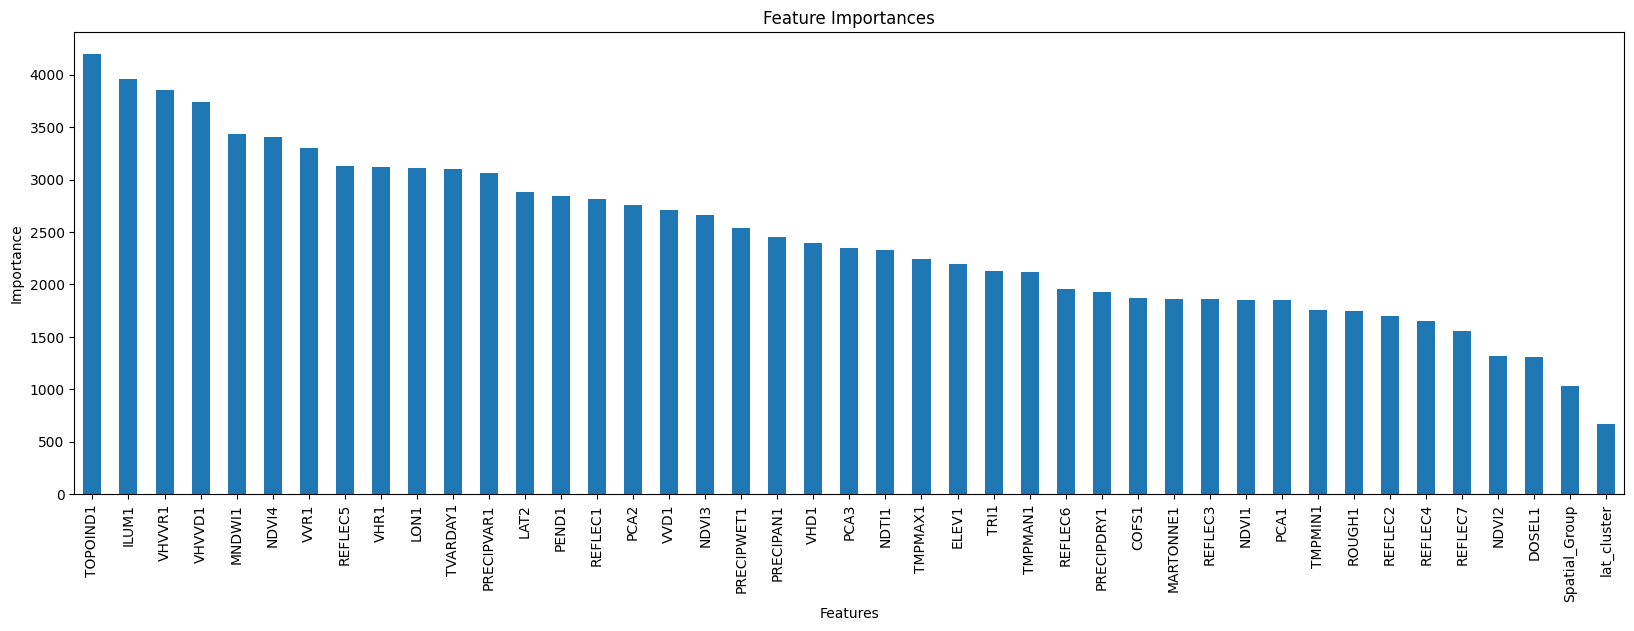

In [11]:
importances = model.feature_importances_
names = model.feature_name_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(20, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()